# QUANTITATIVE TRADING STRATEGIES - HW 5

## FX Carry Strategy

**Name**: Adriana Mata

**Date**: 06/02/2024

# 1. Introduction 

The Foreign Exchange (FX) carry strategy is a financial tactic that exploits the differential in interest rates between two currencies. By borrowing in a currency with a lower interest rate and lending in a currency with a higher interest rate, investors aim to capture the interest rate spread, potentially earning profits through this differential. This strategy is often executed through the use of cross-currency swaps, which allow investors to swap their obligations in one currency for obligations in another, effectively lending in one currency and borrowing in another.

In our exploration of the Foreign Exchange (FX) carry strategy, we have selected a diverse set of currencies that present unique opportunities and risks based on their economic environments, interest rate levels, and foreign exchange dynamics. Here is an explanation for the choice of each specific currency:

*  **Egyptian Pound (EGP)**: The EGP represents an interesting case due to Egypt's distinct economic conditions, including higher inflation rates and interest rates compared to developed markets. The country's monetary policy and economic reforms, especially in recent years, have led to significant fluctuations in the EGP's value and interest rates, making it a potentially lucrative option for carry trades.

* **Hungarian Forint (HUF)**: Hungary's currency is chosen due to its position within the European emerging markets. The HUF's interest rates are influenced by Hungary's central bank policies, which often aim to balance growth with inflation control. The HUF might offer attractive yield differentials relative to currencies from lower interest rate environments.

* **Costa Rican Colon (CRC)**: As a currency from a smaller, open economy, the CRC is subject to volatility influenced by both domestic economic conditions and external factors such as commodity prices and trade flows. Costa Rica's interest rate environment can provide interesting dynamics for carry trade strategies, especially given the potential for higher yields.

* **Romanian Leu (RON)**: Romania's currency is included due to the country's growing economy within Eastern Europe and its unique position as a frontier market transitioning towards more developed status. The RON might offer favorable interest rate differentials and reflects Romania's economic policies, including those aimed at curbing inflation and fostering stable growth.

* **British Pound (GBP) and US Dollar (USD)**: The GBP and USD are included as major currencies that often serve as the benchmark or funding currencies in carry trades due to their relatively low-interest rates and stability. The GBP/USD spot FX rate is a crucial component of the analysis, providing a baseline for conversions and comparisons with the emerging market currencies.

By analyzing these specific currencies, we aim to capture a wide range of carry trade opportunities across different economic and monetary landscapes. Each currency brings a unique set of factors into the analysis, including interest rate differentials, economic stability, inflation rates, and susceptibility to global financial market shifts.

# 2. Data Manipulation

## 2.1. Data Extraction

The data extraction process involves retrieving financial data from NASDAQ Quandl, bank of England database and a csv file provided in Canvas. This extraction was done using the University of Chicago email account, which provides students with access to a wide variety of data sources and datasets for analysis. We also extracted data from 

Before starting the data extraction, it is necessary to ensure that the required libraries are imported into the Jupyter Notebook file. These libraries, such as Pandas, NumPy, Matplotlib, among others, will be very useful to reduce the length of the code and make tasks more efficient.

In [1443]:
import os
import datetime
import quandl
import config

import pandas as pd
import numpy as np
import scipy as sp
from scipy.fft import fft, fftfreq

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import Normalize

import scipy.stats as stats
from scipy.stats import norm

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

The ``grab_quandl_table`` function is responsible for handling the download of data tables from Quandl. This function has been designed to avoid downloading the same data repeatedly. Hence, it will only grab new data once per day; otherwise, it will use the data from the file cache.

For this function to work, we need to specify the Quandl table path, the path to the directory where we want to store the downloaded data, and the private API Key, which is provided when you create your account on Quandl. If the download is successful and there's no date override, the function creates a symlink to the downloaded file.


In [1444]:
path = os.getcwd()

def grab_quandl_table(table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(path, "quandl_data_table_downloads") # Change this to your own directory
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=config.QUANDL_API_KEY, **kwargs # Private API key
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

This function wraps around the previously defined `grab_quandl_table` to fetch and return a Pandas DataFrame. It reads the downloaded data file into a DataFrame and returns it for further analysis.

In this case, all data regarding ‘AR/IVM’ has been downloaded. This data contains multiple exchange, futures, and options codes, as well as multiple expiration numbers. This data will be sorted and cleaned in the upcoming steps, as we are only focusing on two specific pairs of futures.

In [1445]:
t_ivm = fetch_quandl_table('EDI/CUR', avoid_download=False)
t_ivm.head()

Data file /Users/adriana/Jupyter_Files/FINM33150_Quantitative_Trading_Strategies/Homework/quandl_data_table_downloads/EDI/CUR_20240215.zip size 7449838 exists already, no need to download


,code,date,rate
0,AED,2023-07-20,3.672900
1,AFN,2023-07-20,85.664367
2,ALL,2023-07-20,90.165179
3,AMD,2023-07-20,389.973810
4,ANG,2023-07-20,1.801893


The yield curve data was accessed from Canvas. This table encompasses data for multiple currencies, each with various tenors, dates, and corresponding yield values. This dataset will prove invaluable for subsequent computations involving zero-coupon bonds and for utilization as lending rates throughout the homework assignment.

In [1446]:
import_path = "/Users/adriana/Jupyter_Files/FINM33150_Quantitative_Trading_Strategies/Homework/FX_Data/InferredYieldCurves_2024.tab"
YC = pd.read_csv(import_path, sep='\t')
YC.drop(columns=['Unnamed: 0'], inplace=True)
YC.head()

,shortname,tenor,date,yield
0,Arab Rep Egypt,10Y,2010-01-04,0.075885
1,Arab Rep Egypt,10Y,2010-01-05,0.074642
2,Arab Rep Egypt,10Y,2010-01-06,0.074318
3,Arab Rep Egypt,10Y,2010-01-07,0.073642
4,Arab Rep Egypt,10Y,2010-01-08,0.073024


The Bank of America has furnished the data on the Daily Sterling Overnight Index Average (SONIA) rate. This rate will serve as the benchmark for borrowing money in the context of our analysis representing the cost of borrowing in a low-interest-rate environment.

In [1447]:
import_path = "/Users/adriana/Jupyter_Files/FINM33150_Quantitative_Trading_Strategies/Homework/FX_Data/Bank of England  Database.csv"
boe_rates = pd.read_csv(import_path, sep=',')
boe_rates['Date'] = pd.to_datetime(boe_rates['Date'], format='%d %b %y')
boe_rates.set_index('Date', inplace=True)
boe_rates.rename(columns={'Daily Sterling overnight index average (SONIA) rate              [a] [b]             IUDSOIA': 'IUDSOIA'}, inplace=True)
boe_rates.head()

,IUDSOIA
Date,
2024-02-09,5.1885
2024-02-08,5.1880
2024-02-07,5.1890
2024-02-06,5.1894
2024-02-05,5.1884


## 2.2. Data Cleaning

The `filter_currency` function is designed to return a DataFrame filtered by the specified currency code. This function will be used to obtain multiple dataframes corresponding each one of them to one specific fx rate. 

The `set_date_index` function is designed to convert the 'date' column to datetime format, sets it as the index, and sorts the DataFrame by date, to ensure a good treatment of information of each dataframe. 

In [1448]:
def filter_currency(currency, df):
    currency = df[df['code'] == currency]
    currency = currency.drop(columns=['code'])
    return currency

def set_date_index(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    return df

Then, all the previous functions will be applied and multiple dataframes will be generated. 

In [1449]:
EGP_data = filter_currency('EGP', t_ivm)
EGP_data = set_date_index(EGP_data)

HUF_data = filter_currency('HUF', t_ivm)
HUF_data = set_date_index(HUF_data)

CRC_data = filter_currency('CRC', t_ivm)
CRC_data = set_date_index(CRC_data)

RON_data = filter_currency('RON', t_ivm)
RON_data = set_date_index(RON_data)

GBP_data = filter_currency('GBP', t_ivm)
GBP_data = set_date_index(GBP_data)

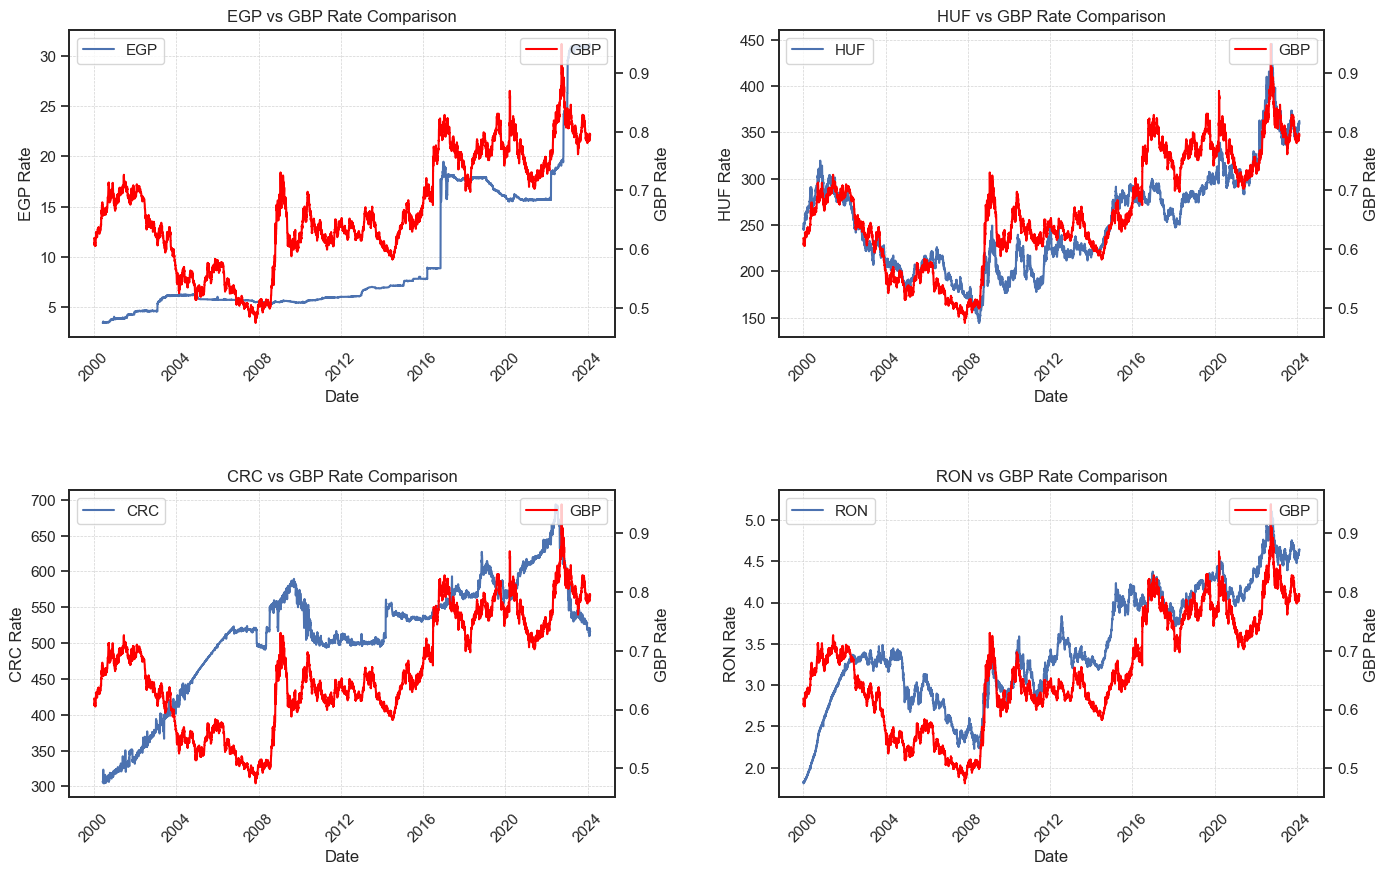

In [1450]:
def plot_currency_comparison(ax, currency_data, gbp_data, currency_label, gbp_label='GBP'):

    # EBP/HUF/CRC/RON data y-axis
    ax.plot(currency_data.index, currency_data['rate'], label=currency_label)
    ax.set_ylabel(currency_label + ' Rate')
    ax.tick_params(axis='y')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
    
    # GBP data
    ax_gbp = ax.twinx()
    ax_gbp.plot(gbp_data.index, gbp_data['rate'], label=gbp_label, color='red')
    ax_gbp.set_ylabel(gbp_label + ' Rate')
    ax_gbp.tick_params(axis='y')

    ax.set_title(f'{currency_label} vs {gbp_label} Rate Comparison')
    ax.set_xlabel('Date')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc='upper left')
    ax_gbp.legend(loc='upper right')

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.tight_layout(pad=6.0)

plot_currency_comparison(axs[0, 0], EGP_data, GBP_data, 'EGP')
plot_currency_comparison(axs[0, 1], HUF_data, GBP_data, 'HUF')
plot_currency_comparison(axs[1, 0], CRC_data, GBP_data, 'CRC')
plot_currency_comparison(axs[1, 1], RON_data, GBP_data, 'RON')

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()


The previous plots display four line graphs, each comparing the exchange rates of different currencies against the British Pound (GBP) over time.

**EGP vs GBP Rate Comparison**: This graph compares the Egyptian Pound (EGP) and the British Pound (GBP). The EGP rate appears to be much higher in numerical value than the GBP rate, indicating that this might be the EGP to GBP conversion rate, which normally would be greater than one. Also the GBP line oscilates over time unlike the EGP that remains stable over long periods of time. 

**HUF vs GBP Rate Comparison**: Similar to the first graph, this one shows the comparison between the Hungarian Forint (HUF) and GBP. The pattern suggests fluctuating exchange rates over time, with the HUF rate consistently higher than that of the GBP, which is expected due to the nature of the currencies.

**CRC vs GBP Rate Comparison**: This graph compares the Costa Rican Colon (CRC) to the GBP. The CRC rate in blue is considerably higher than the GBP rate in red, moreover, the CRC exchange rate experiences a significant spike, which indicate a period of devaluation or other economic events.

**RON vs GBP Rate Comparison**: The final graph shows the Romanian Leu (RON) against the GBP.

The `choose_tenor` function is designed to filter any dataFrame to include only rows where the 'tenor' column matches the specified tenor value.

The `filter_short_name` function is designed to return a DataFrame filtered by the specified short name. Ths function will be applied to the yield curves. 

The `change_tenor_name` function is designed to map the tenor names in the 'tenor' column  to their corresponding numerical values defined in tenor_mapping.

In [1451]:
def choose_tenor(data, tenor):
    data = data[data['tenor'] == tenor]
    return data

def filter_short_name(name, df):
    name = df[df['shortname'] == name]
    name = name.drop(columns=['shortname'])
    return name

def change_tenor_name(data):
    tenor_mapping = {'5Y': 5, '10Y': 10, '1Y': 1, '6M': 0.5}
    data['tenor'] = data['tenor'].map(tenor_mapping)
    
    return data

Then, all the previous functions will be applied and multiple dataframes will be generated. 

In [1452]:
EGP_YC = filter_short_name('Arab Rep Egypt', YC)
EGP_YC = set_date_index(EGP_YC)
EGP_YC = change_tenor_name(EGP_YC)

HUF_YC = filter_short_name('Hungary', YC)
HUF_YC = set_date_index(HUF_YC)
HUF_YC = change_tenor_name(HUF_YC)

CRC_YC = filter_short_name('Rep Costa Rica', YC)
CRC_YC = set_date_index(CRC_YC)
CRC_YC = change_tenor_name(CRC_YC)

RON_YC = filter_short_name('Romania', YC)
RON_YC = set_date_index(RON_YC)
RON_YC = change_tenor_name(RON_YC)

We will also generate four extra dataframes to extract only the information corresponding to the 5 years tenor.

In [1453]:
EGP_YC_5 = choose_tenor(EGP_YC, 5)
HUF_YC_5 = choose_tenor(HUF_YC, 5)
CRC_YC_5 = choose_tenor(CRC_YC, 5)
RON_YC_5 = choose_tenor(RON_YC, 5)

Using the previously defined DataFrames, we can generate four subplots to visually analyze the data and identify potential correlations among them.

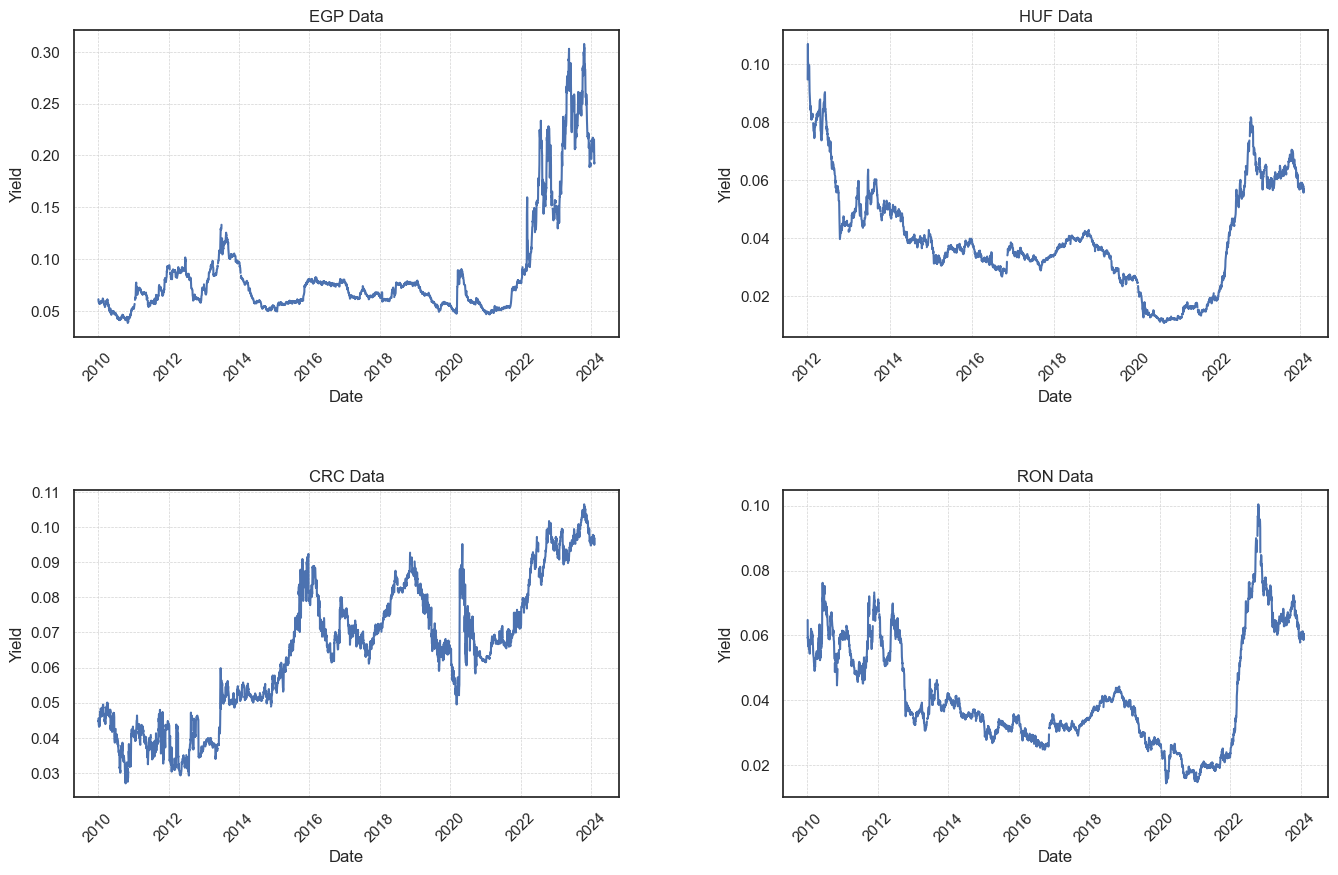

In [1454]:
def plot_currency_data(ax, data, title, xlabel='Date', ylabel='Rate'):
    ax.plot(data.index, data['yield'])
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
    ax.tick_params(axis='x', rotation=45)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.tight_layout(pad=6.0)

plot_currency_data(axs[0, 0], EGP_YC_5, 'EGP Data', ylabel='Yield')
plot_currency_data(axs[0, 1], HUF_YC_5, 'HUF Data', ylabel='Yield')
plot_currency_data(axs[1, 0], CRC_YC_5, 'CRC Data', ylabel='Yield')
plot_currency_data(axs[1, 1], RON_YC_5, 'RON Data', ylabel='Yield')

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

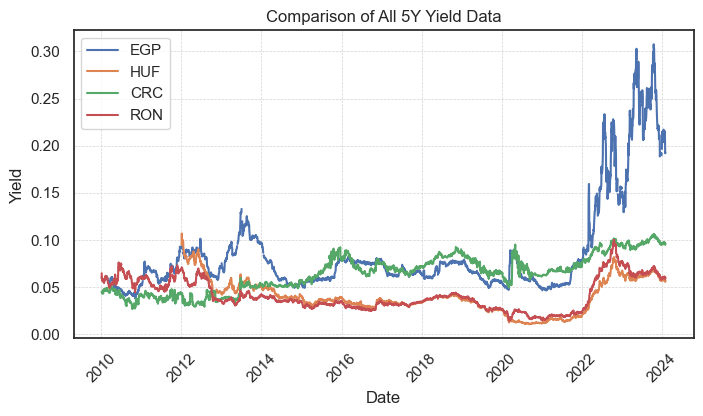

In [1455]:
plt.figure(figsize=(8, 4)) 

plt.plot(EGP_YC_5.index, EGP_YC_5['yield'], label='EGP')
plt.plot(HUF_YC_5.index, HUF_YC_5['yield'], label='HUF')
plt.plot(CRC_YC_5.index, CRC_YC_5['yield'], label='CRC')
plt.plot(RON_YC_5.index, RON_YC_5['yield'], label='RON')

plt.title('Comparison of All 5Y Yield Data')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
plt.xticks(rotation=45) 
plt.show()

This graph compares the 5-year (5Y) bond yields for four different currencies over time. The currencies represented are the Egyptian Pound (EGP), Hungarian Forint (HUF), Costa Rican Colon (CRC), and Romanian Leu (RON).

The EGP yield (blue line) exhibits significant volatility and shows a sharp increase starting around 2022, suggesting a period of increased risk perception. The HUF yield (green line) also shows volatility with a few peaks and troughs but generally remains in the middle range of the values plotted. The CRC yield (orange line) remains relatively low and stable until around 2021, where it begins to increase and the same trend can be observed from the RON yield (red line).

Overall, the graph indicates that there was relatively more stability in the yields of these bonds before 2021. After 2021, there is an upward trend in yields, especially noticeable for the EGP. This could be due to the pandemic, or due to inflation expectations. 

Finally, we will graph the Daily Sterling Overnight Index Average (SONIA) rate, providing a visual representation of borrowing costs. To enhance visualization, we will include the rates corresponding to the last five years, offering a broader perspective on rate trends over time.

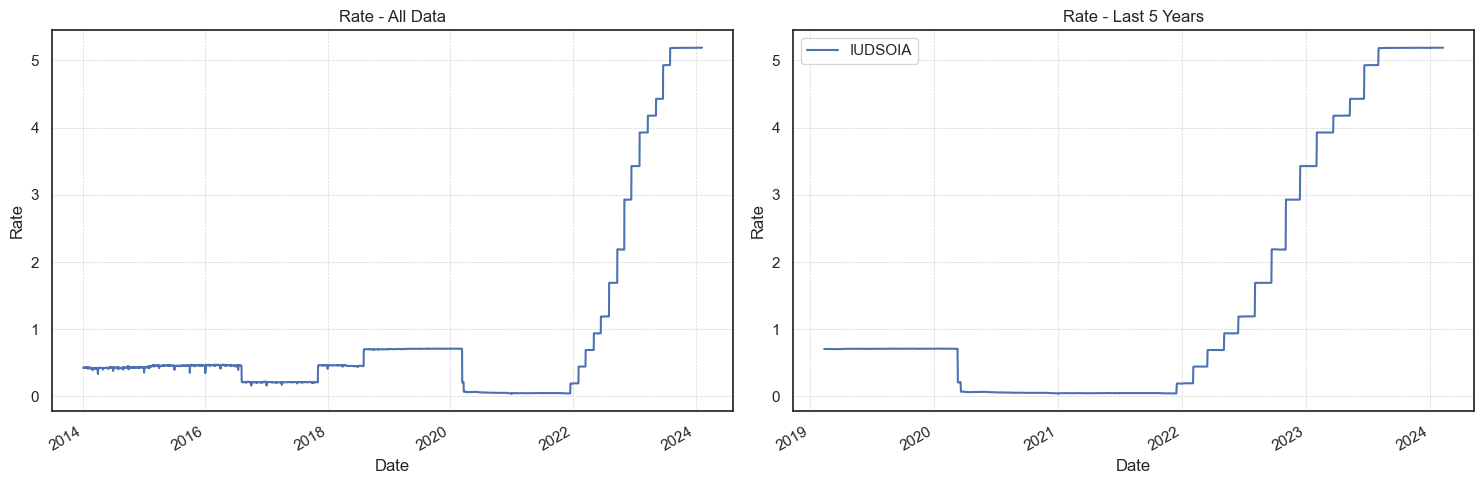

In [1456]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

boe_rates['IUDSOIA'].plot(ax=axs[0])
axs[0].set_title('Rate - All Data')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Rate')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

boe_rates.index = pd.to_datetime(boe_rates.index)
end_date = boe_rates.index.max()  
start_date = end_date - pd.DateOffset(years=5)
boe_rates_5yr = boe_rates.loc[end_date:start_date]
boe_rates_5yr.plot(ax=axs[1])
axs[1].set_title('Rate - Last 5 Years')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Rate')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

plt.tight_layout()
plt.show()


**Resample the data to Weekly frequency**

Now we will resample the data weekly to align the observations to a consistent weekly frequency, specifically on Wednesdays. This ensures uniformity in the data and facilitates easier comparison and analysis over time, particularly since the original data is recorded on different days of the week.

In [1457]:
EGP_data = EGP_data.resample('W-WED').asfreq()
HUF_data = HUF_data.resample('W-WED').asfreq()
CRC_data = CRC_data.resample('W-WED').asfreq()
RON_data = RON_data.resample('W-WED').asfreq()
GBP_data = GBP_data.resample('W-WED').asfreq()

In [1458]:
boe_rates = boe_rates.resample('W-WED').asfreq().fillna(method='ffill')

## 2.3. Data Computation

**Computing Zero Coupon Bond**

The `compute_zcb_curve` function is designes to calculate the zero-coupon bond (ZCB) rates from a given set of spot rates for different tenors. It iterates over each tenor in the spot rate curve, using linear interpolation to estimate the value of preceding coupons, and then solves for the ZCB rate that equates the present value of future cash flows to the bond's price. This is done by discounting the coupons and principal at the calculated ZCB rate, ensuring that the sum of the present values equals 1 for a zero-coupon bond.

In [1459]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
    return zcb_rates


In [1460]:
EGP_YC_pivot = pd.pivot_table(EGP_YC, values='yield', index=['tenor'], columns=['date'], aggfunc=np.sum)
HUF_YC_pivot = pd.pivot_table(HUF_YC, values='yield', index=['tenor'], columns=['date'], aggfunc=np.sum)
CRC_YC_pivot = pd.pivot_table(CRC_YC, values='yield', index=['tenor'], columns=['date'], aggfunc=np.sum)
RON_YC_pivot = pd.pivot_table(RON_YC, values='yield', index=['tenor'], columns=['date'], aggfunc=np.sum)

In [1461]:
EGP_YC_pivot = EGP_YC_pivot.T.interpolate(axis=0, method='index').T
HUF_YC_pivot = HUF_YC_pivot.T.interpolate(axis=0, method='index').T
CRC_YC_pivot = CRC_YC_pivot.T.interpolate(axis=0, method='index').T
RON_YC_pivot = RON_YC_pivot.T.interpolate(axis=0, method='index').T

Here we extract the zero coupond bonds curves

In [1462]:
EGP_YC_zcb = compute_zcb_curve(EGP_YC_pivot)
HUF_YC_zcb = compute_zcb_curve(HUF_YC_pivot)
CRC_YC_zcb = compute_zcb_curve(CRC_YC_pivot)
RON_YC_zcb = compute_zcb_curve(RON_YC_pivot)

**Resample the zero coupon curves**

The previously computed curves will also be resampled on a weekly basis to align observations and ensure uniformity in the data. 

In [1463]:
EGP_YC_zcb = EGP_YC_zcb.T.resample('W-WED').last().fillna(method='ffill').T
HUF_YC_zcb = HUF_YC_zcb.T.resample('W-WED').last().fillna(method='ffill').T
CRC_YC_zcb = CRC_YC_zcb.T.resample('W-WED').last().fillna(method='ffill').T
RON_YC_zcb = RON_YC_zcb.T.resample('W-WED').last().fillna(method='ffill').T

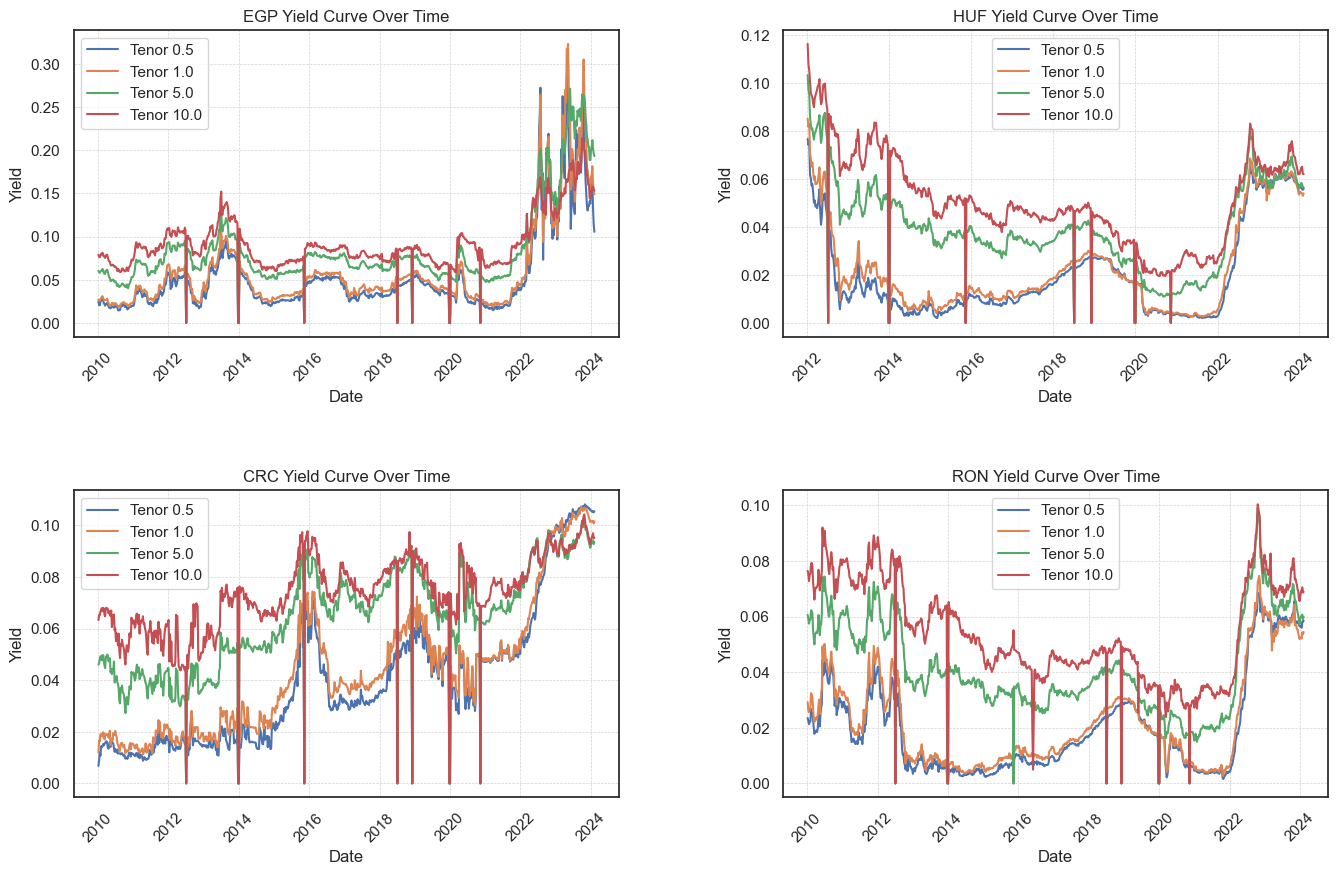

In [1464]:
EGP_YC_zcb_T = EGP_YC_zcb.T
HUF_YC_zcb_T = HUF_YC_zcb.T
CRC_YC_zcb_T = CRC_YC_zcb.T
RON_YC_zcb_T = RON_YC_zcb.T

def plot_yield_curve(ax, df, title_name):

    for tenor in df.columns:
        ax.plot(df.index, df[tenor], label=f'Tenor {tenor}')

    ax.set_title(f'{title_name} Yield Curve Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Yield')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.tight_layout(pad=6.0)

plot_yield_curve(axs[0, 0], EGP_YC_zcb_T, title_name='EGP')
plot_yield_curve(axs[0, 1], HUF_YC_zcb_T, title_name='HUF')
plot_yield_curve(axs[1, 0], CRC_YC_zcb_T, title_name='CRC')
plot_yield_curve(axs[1, 1], RON_YC_zcb_T, title_name='RON')

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()


The subplots shows how yields with different tenors (0.5 years, 1 year, 5 years, and 10 years) have changed from 2014 to beyond 2024. 

Each currency exhibits periods of volatility where yields fluctuate significantly. However, all the peaks across the graphs that have a value of zero suggest that there is no yield informaiton on these dates. There are instances where all tenors move in the same direction, which is indicative of a shift in the entire yield curve. 

Also, from the shapes of the yield curves (relationship between yields and tenors) we can see that they change over time. Normally, a higher yield for longer tenors (a normal yield curve) suggests a healthy economy, while an inverted curve (higher yields for shorter tenors) can be a sign of economic downturn expectations.

As stated before,  all currencies experience a rise in yields towards the end of the observed period. This suggests a regional or global economic trend, such as tightening monetary policy or a reaction to inflationary pressures.

**Calculating the Bond Price**

The `bond_price` function calculates the price of a coupon-paying bond based on a provided zero-coupon bond (ZCB) yield curve, a coupon rate, and the bond's tenor. It does so by discounting future cash flows (both the periodic coupon payments and the final principal repayment) at the interpolated rates from the ZCB yield curve corresponding to payment times. The bond price is the sum of these discounted cash flows, providing the present value of the bond.

In [1465]:
def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.25)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.25 * coupon_rate * np.exp(-r*times).sum()
    return p


The `bond_price_dataframe` function computes the prices of bonds with a 5-year tenor based on a yield curve dataframe and zero-coupon bond rates. It extracts weekly coupon rates for 5-year tenors from yield_df, then uses these rates along with the corresponding zero-coupon rates from zcb to calculate bond prices using the `bond_price` function.

In [1466]:
def bond_price_dataframe(yield_df, zcb):
    bond_prices = []
    
    coupon_rates = yield_df[yield_df['tenor'] == 5].resample('W-WED').last().fillna(method='ffill')
    
    for date in coupon_rates.index:
        coupon_rate = coupon_rates.loc[coupon_rates.index == date, 'yield'].iloc[0]
        tenor = 5
        yield_rate = zcb[date]
        price = bond_price(yield_rate, coupon_rate, tenor)
        bond_prices.append(price)
    
    bond_prices_df = pd.DataFrame(bond_prices, index=zcb.columns).T
    bond_prices_df.columns = zcb.columns
    
    return bond_prices_df

In [1467]:
bond_price_EGP = bond_price_dataframe(EGP_YC, EGP_YC_zcb).T.rename(columns={0: 'Price_EGP'})
bond_price_HUF = bond_price_dataframe(HUF_YC, HUF_YC_zcb).T.rename(columns={0: 'Price_HUF'})
bond_price_CRC = bond_price_dataframe(CRC_YC, CRC_YC_zcb).T.rename(columns={0: 'Price_CRC'})
bond_price_RON = bond_price_dataframe(RON_YC, RON_YC_zcb).T.rename(columns={0: 'Price_RON'})

**Calculating the Bond Exit Price**

The `bond_exit_price_dataframe` function estimates the prices of 5-year tenor bonds, adjusted for a week's passage of time (hence a tenor of 5 - 1/52 years), using a given yield curve and future zero-coupon bond rates. It calculates bond prices by interpolating future yields (shifted one period forward) and the weekly coupon rates, then compiles these prices into a new DataFrame with dates as columns. The function is designed to provide an anticipated bond price for an exit strategy one week in the future.

In [1468]:
def bond_exit_price_dataframe(yield_df, zcb):
    bond_prices = []
    
    coupon_rates = yield_df[yield_df['tenor'] == 5].resample('W-WED').last().fillna(method='ffill')
    
    for date in coupon_rates.index:
        coupon_rate = coupon_rates.loc[coupon_rates.index == date, 'yield'].iloc[0]
        tenor = 5 - (1/52)
        yield_rate = zcb[date].shift(-1)
        price = bond_price(yield_rate, coupon_rate, tenor)
        bond_prices.append(price)
    
    bond_prices_df = pd.DataFrame(bond_prices, index=zcb.columns).T
    bond_prices_df.columns = zcb.columns
    
    return bond_prices_df

In [1469]:
bond_exit_price_EGP = bond_exit_price_dataframe(EGP_YC, EGP_YC_zcb).T.rename(columns={0: 'Exit_Price'})
bond_exit_price_HUF = bond_exit_price_dataframe(HUF_YC, HUF_YC_zcb).T.rename(columns={0: 'Exit_Price'})
bond_exit_price_CRC = bond_exit_price_dataframe(CRC_YC, CRC_YC_zcb).T.rename(columns={0: 'Exit_Price'})
bond_exit_price_RON = bond_exit_price_dataframe(RON_YC, RON_YC_zcb).T.rename(columns={0: 'Exit_Price'})

# 3. Fixed-Float Carry Strategy

This carry trade strategy is predicated on the differential between the 5-year swap rates of two currencies, termed here as the lending and borrowing currencies. The approach is structured around leveraging differences in interest rates to generate returns. 

**Signal Determination:** A trading signal is generated based on the comparison between the 5-year swap rates of the lending and borrowing currencies. Specifically, a signal value of 1 is assigned if the 5-year swap rate of the lending currency exceeds that of the borrowing currency by at least 50 basis points (bps). This signal indicates a favorable condition for initiating the carry trade.

**Borrowing Position Entry:** Upon receiving a positive signal, the strategy involves entering a borrowing position in the funding (or borrowing) currency. The borrowing cost is assumed to be the Overnight Indexed Swap (OIS) rate plus a 50 bps spread. The borrowing is executed on four-fifths of the notional amount, effectively creating a leverage of 5x in the borrowing currency for each active position.

**Borrowing Position Exit:** Exiting the borrowing position necessitates the calculation of accrued interest, factoring in both the borrow and lend rates. Additionally, a mark-to-market evaluation for the swap exit is required to assess the position's profitability or loss at the time of exit.

**Lending Position Entry:** Simultaneously with entering the borrowing position, a lending position is initiated by investing in bonds denominated in the lending currency. The investment covers the total notional amount, aiming to capitalize on the interest rate differential between the lending and borrowing currencies.

**Lending Position Exit:** The exit strategy for the lending position involves liquidating the bond investment. The return on this investment is determined by multiplying the initial investment by the ratio of the bond's exit price to its entry price. This figure is then adjusted for the lending exchange rate to calculate the final return from the lending position.

**Setting the same index for all the dataframes**

In [1470]:
index_common = EGP_YC.index.intersection(boe_rates.index)

EGP_YC_zcb = EGP_YC_zcb.T.loc[index_common]
HUF_YC_zcb = HUF_YC_zcb.T.loc[index_common]
CRC_YC_zcb = CRC_YC_zcb.T.loc[index_common]
RON_YC_zcb = RON_YC_zcb.T.loc[index_common]

boe_rates = boe_rates.loc[index_common] / 100

EGP_YC = EGP_YC.loc[index_common]
HUF_YC = HUF_YC.loc[index_common]
CRC_YC = CRC_YC.loc[index_common]
RON_YC = RON_YC.loc[index_common]

EGP_YC_5 = EGP_YC_5.loc[index_common]
HUF_YC_5 = HUF_YC_5.loc[index_common]
CRC_YC_5 = CRC_YC_5.loc[index_common]
RON_YC_5 = RON_YC_5.loc[index_common]

EGP_data = EGP_data.loc[index_common]
HUF_data = HUF_data.loc[index_common]
CRC_data = CRC_data.loc[index_common]
RON_data = RON_data.loc[index_common]
GBP_data = GBP_data.loc[index_common]

bond_exit_price_EGP = bond_exit_price_EGP.loc[index_common]
bond_exit_price_HUF = bond_exit_price_HUF.loc[index_common]
bond_exit_price_CRC = bond_exit_price_CRC.loc[index_common]
bond_exit_price_RON = bond_exit_price_RON.loc[index_common]


**Signal Determination**

The `signal_generation` function creates trading signals based on the difference between lending and borrowing rates for a specified tenor. It generates a DataFrame with a 'signal' column, where a signal value of 1 is assigned if the lending rate exceeds the borrowing rate by more than 0.005 (50 basis points), and 0 otherwise. This signal indicates whether it's beneficial to engage in a lending transaction over borrowing, considering a margin of 0.005 as the threshold for action.

In [1471]:
def signal_generation(rate_lending,rate_borrowing,index_common):
    
    tenor = 5

    signal = pd.DataFrame(index=index_common)
    lending_rates_for_tenor = rate_lending[rate_lending['tenor'] == tenor]['yield']
    lending_rates_for_tenor = pd.DataFrame(lending_rates_for_tenor, index=index_common)
    signal['signal'] = np.where(lending_rates_for_tenor.values > rate_borrowing.values+0.005, 1, 0)

    return signal

**Borrowing Strategy**

The `borrowing_USD_GBP` function calculates the profit or loss (PnL) from borrowing USD, converting it to GBP based on a forex rate, and then repaying the loan, taking into account interest and exchange rate changes. It applies a leverage of 4/5 to the notional amount of 10 million (in USD) and only initiates the transaction when the signal from `signal_df` is 1, implying favorable lending conditions. The function returns a DataFrame with detailed borrowing information and the PnL for each date where the signal is active.

In [1472]:
def borrowing_USD_GBP(rate_borrowing, fx_rate_borrowing, signal_df):
    
    notional = 10e6
    leverage = 4/5

    borrowing = pd.DataFrame(index=signal_df.index)

    if isinstance(rate_borrowing, pd.Series):
        rate_borrowing = rate_borrowing.to_frame('IUDSOIA')
    if isinstance(fx_rate_borrowing, pd.Series):
        fx_rate_borrowing = fx_rate_borrowing.to_frame('rate')

    for date in signal_df.index:
        if signal_df.loc[date, 'signal'] == 1:
            interest_rate = rate_borrowing.loc[date, 'IUDSOIA'] + 0.005

            borrowed_usd = notional * leverage
            borrowed_gbp = borrowed_usd * fx_rate_borrowing.loc[date, 'rate']
            
            interest_gbp = interest_rate / 52 * borrowed_gbp

            borrowed_usd_end = borrowed_gbp / fx_rate_borrowing['rate'].shift(-1).get(date, np.nan)
            interest_usd = interest_gbp / fx_rate_borrowing['rate'].shift(-1).get(date, np.nan)

            pnl = borrowed_usd - borrowed_usd_end - interest_usd

            borrowing.at[date, 'Interest_rate'] = interest_rate
            borrowing.at[date, 'Borrowed USD'] = borrowed_usd
            borrowing.at[date, 'Borrowed GBP'] = borrowed_gbp
            borrowing.at[date, 'Interest GBP'] = interest_gbp
            borrowing.at[date, 'Borrowed USD End'] = borrowed_usd_end
            borrowing.at[date, 'Interest USD'] = interest_usd
            borrowing.at[date, 'PnL'] = pnl

    borrowing.fillna(0, inplace=True)

    return borrowing


**Lending Strategy**

The `lending_fx_currency` function simulates the process and calculates the profit or loss of a lending trade in a foreign currency bond market. When the signal is positive, it converts a notional USD amount to a foreign currency at the current FX rate, uses that to buy bonds at a fixed entry price, and then calculates the exit proceeds from selling the bonds at a future date's exit price, reconverting the proceeds back to USD.

In [1473]:
def lending_fx_currency(fx_rate_lending, bond_exit_price, signal_df):

    notional = 10e6
    bonds_entry_price = 1

    lending = pd.DataFrame(index=signal_df.index, columns=[
        'Loan', 'Converted USD', 'Bonds Bought', 'bond_exit_price',
        'Sell Amount Lending Currency', 'Reconverted USD', 'PnL'
    ])
    
    for date in signal_df.index:
        if signal_df.loc[date, 'signal'] == 1:
            loan = notional
            converted_usd = loan * fx_rate_lending.loc[date, 'rate']

            bonds_bought = converted_usd / bonds_entry_price
            bonds_exit_price = bond_exit_price.loc[date]['Exit_Price']
            sell_amount_lending_currency = bonds_bought * bonds_exit_price
            reconverted_usd = sell_amount_lending_currency / fx_rate_lending.shift(-1).loc[date, 'rate']

            pnl = reconverted_usd - loan

            lending.at[date, 'Loan'] = loan
            lending.at[date, 'Converted USD'] = converted_usd
            lending.at[date, 'Bonds Bought'] = bonds_bought
            lending.at[date, 'bond_exit_price'] = bonds_exit_price
            lending.at[date, 'Sell Amount Lending Currency'] = sell_amount_lending_currency
            lending.at[date, 'Reconverted USD'] = reconverted_usd
            lending.at[date, 'PnL'] = pnl

    lending.fillna(0, inplace=True)

    return lending


**Calculate Strategy PnL**

The `calculate_pnl` function computes the profit and loss (PnL) from borrowing and lending activities as outlined in `borrowing_df` and `lending_df`, against signals indicated in `signal_df`. It calculates the total and cumulative PnL for both activities, as well as the cumulative interest in USD and the strategy return based on a defined investment amount. The resulting DataFrame is adjusted to align transactions with their respective signals by shifting the data by one period and removing any resulting missing values.

In [1474]:
def calculate_pnl(borrowing_df,lending_df,signal_df):

    investment_amount = 2e6

    pnl = pd.DataFrame(index=signal_df.index, columns=[
        'PnL Borrow', 'PnL Lending', 'Total PnL', 'Cumulative PnL'
    ])

    pnl['PnL Borrow'] = borrowing_df['PnL']
    pnl['PnL Lending'] = lending_df['PnL']
    pnl['Total PnL'] = pnl['PnL Borrow'] + pnl['PnL Lending']

    pnl.fillna(0, inplace=True)
    pnl['Cumulative PnL'] = -pnl['Total PnL'].cumsum()/10
    pnl['Cumulative PnL Borrow'] = pnl['PnL Borrow'].cumsum()
    pnl['Cumulative PnL Lending'] = pnl['PnL Lending'].cumsum()
    pnl['Cumulative Interest USD'] = borrowing_df['Interest USD'].cumsum()

    pnl['Strategy Return'] = pnl['Total PnL'] / investment_amount
    pnl.shift(1).dropna(inplace=True)

    return pnl
    

## 3.1. Strategy Outputs

In [1475]:
signal_EGP = signal_generation(EGP_YC,boe_rates,index_common)
signal_HUF = signal_generation(HUF_YC,boe_rates,index_common)
signal_CRC = signal_generation(CRC_YC,boe_rates,index_common)
signal_RON = signal_generation(RON_YC,boe_rates,index_common)

In [1476]:
EGP_lending = lending_fx_currency(EGP_data, bond_exit_price_EGP, signal_EGP)
HUF_lending = lending_fx_currency(HUF_data, bond_exit_price_HUF, signal_HUF)
CRC_lending = lending_fx_currency(CRC_data, bond_exit_price_CRC, signal_CRC)
RON_lending = lending_fx_currency(RON_data, bond_exit_price_RON, signal_RON)

In [1477]:
EGP_borrowing = borrowing_USD_GBP(boe_rates, GBP_data, signal_EGP)
HUF_borrowing = borrowing_USD_GBP(boe_rates, GBP_data, signal_HUF)
CRC_borrowing = borrowing_USD_GBP(boe_rates, GBP_data, signal_CRC)
RON_borrowing = borrowing_USD_GBP(boe_rates, GBP_data, signal_RON)

In [1478]:
EGP_pnl = calculate_pnl(EGP_borrowing,EGP_lending,signal_EGP)
HUF_pnl = calculate_pnl(HUF_borrowing,HUF_lending,signal_HUF)
CRC_pnl = calculate_pnl(CRC_borrowing,CRC_lending,signal_CRC)
RON_pnl = calculate_pnl(RON_borrowing,RON_lending,signal_RON)

**Plot the PnL Table**

The `plot_financial_metrics` function visualizes four different financial metrics from a given DataFrame across four subplots within a single figure. It plots `Total PnL`, `Cumulative PnL`, `Cumulative Interest USD`, and `Strategy Return`, with additional horizontal lines on the `Strategy Return` subplot to indicate mean, 25th percentile, and 75th percentile values.

In [1479]:
def plot_financial_metrics(df):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Financial Metrics Over Time')

    # Total PnL
    axs[0, 0].plot(df.index, df['Total PnL'])
    axs[0, 0].set_title('Total PnL')
    axs[0, 0].set_xlabel('Date')
    axs[0, 0].set_ylabel('Total PnL')
    axs[0, 0].tick_params(axis='x', rotation=45)
    axs[0, 0].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

    # Cumulative PnL
    axs[0, 1].plot(df.index, df['Cumulative PnL'])
    axs[0, 1].set_title('Cumulative PnL')
    axs[0, 1].set_xlabel('Date')
    axs[0, 1].set_ylabel('Cumulative PnL')
    axs[0, 1].tick_params(axis='x', rotation=45)
    axs[0, 1].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

    # Cumulative Interest USD
    axs[1, 0].plot(df.index, df['Cumulative Interest USD'])
    axs[1, 0].set_title('Cumulative Interest USD')
    axs[1, 0].set_xlabel('Date')
    axs[1, 0].set_ylabel('Cumulative Interest USD')
    axs[1, 0].tick_params(axis='x', rotation=45)
    axs[1, 0].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

    # Strategy Return
    axs[1, 1].plot(df.index, df['Strategy Return'])
    axs[1, 1].axhline(df['Strategy Return'].mean(), color='blue', linestyle='--', label='Mean')
    axs[1, 1].axhline(df['Strategy Return'].quantile(.25), color='red', linestyle='--', label='25% quantile')
    axs[1, 1].axhline(df['Strategy Return'].quantile(.75), color='green', linestyle='--', label='75% quantile')
    axs[1, 1].set_title('Strategy Return')
    axs[1, 1].set_xlabel('Date')
    axs[1, 1].set_ylabel('Strategy Return')
    axs[1, 1].tick_params(axis='x', rotation=45)
    axs[1, 1].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
    axs[1, 1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

**Performance Summary Function**

The `performance_summary` function calculates various risk and performance metrics for a series of investment returns, including mean annualized return, volatility, Sharpe ratio, skewness, kurtosis, Value at Risk (VaR), Conditional Value at Risk (CVaR), quantiles, and maximum drawdown. It then returns these metrics in a rounded DataFrame for easy interpretation.

In [1480]:
def performance_summary(return_series):

    summary_stats = pd.Series()
    summary_stats['Mean'] = return_series.mean() * 12
    summary_stats['Median'] = return_series.median()
    summary_stats['Volatility'] = return_series.std() * np.sqrt(12)
    summary_stats['Sharpe Ratio'] = summary_stats['Mean'] / summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_series.skew()
    summary_stats['Excess Kurtosis'] = return_series.kurtosis()
    summary_stats['VaR (0.05)'] = return_series.quantile(.05)
    summary_stats['CVaR (0.05)'] = return_series[return_series <= return_series.quantile(.05)].mean()
    summary_stats['1% quantile'] = return_series.quantile(.01)
    summary_stats['2% quantile'] = return_series.quantile(.02)
    summary_stats['10% quantile'] = return_series.quantile(.10)
    summary_stats['90% quantile'] = return_series.quantile(.90)
    summary_stats['Min'] = return_series.min()
    summary_stats['Max'] = return_series.max()
    
    cum_returns = (1 + return_series).cumprod()
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max
    summary_stats['max_drawdown'] = drawdown.min()
    
    summary_stats = pd.DataFrame(summary_stats, columns=['Value']).round(3).T

    return summary_stats

## 3.2. Results Analysis

**Egyptian Pound**

In [1481]:
EGP_pnl.head()

,PnL Borrow,PnL Lending,Total PnL,Cumulative PnL,Cumulative PnL Borrow,Cumulative PnL Lending,Cumulative Interest USD,Strategy Return
2014-01-08,37236.934982,-610005.927764,-572768.992782,57276.899278,37236.934982,-6.100059e+05,1421.099541,-0.286384
2014-01-15,-100390.436105,-596200.256668,-696590.692773,126935.968556,-63153.501123,-1.206206e+06,2870.809931,-0.348295
2014-01-22,4374.840488,-582427.170161,-578052.329673,184741.201523,-58778.660635,-1.788633e+06,4298.542844,-0.289026
2014-01-29,119841.721969,-551771.126299,-431929.404330,227934.141956,61063.061334,-2.340404e+06,5703.536675,-0.215965
2014-02-05,-147335.123108,-611106.721001,-758441.844110,303778.326367,-86272.061774,-2.951511e+06,7155.853588,-0.379221


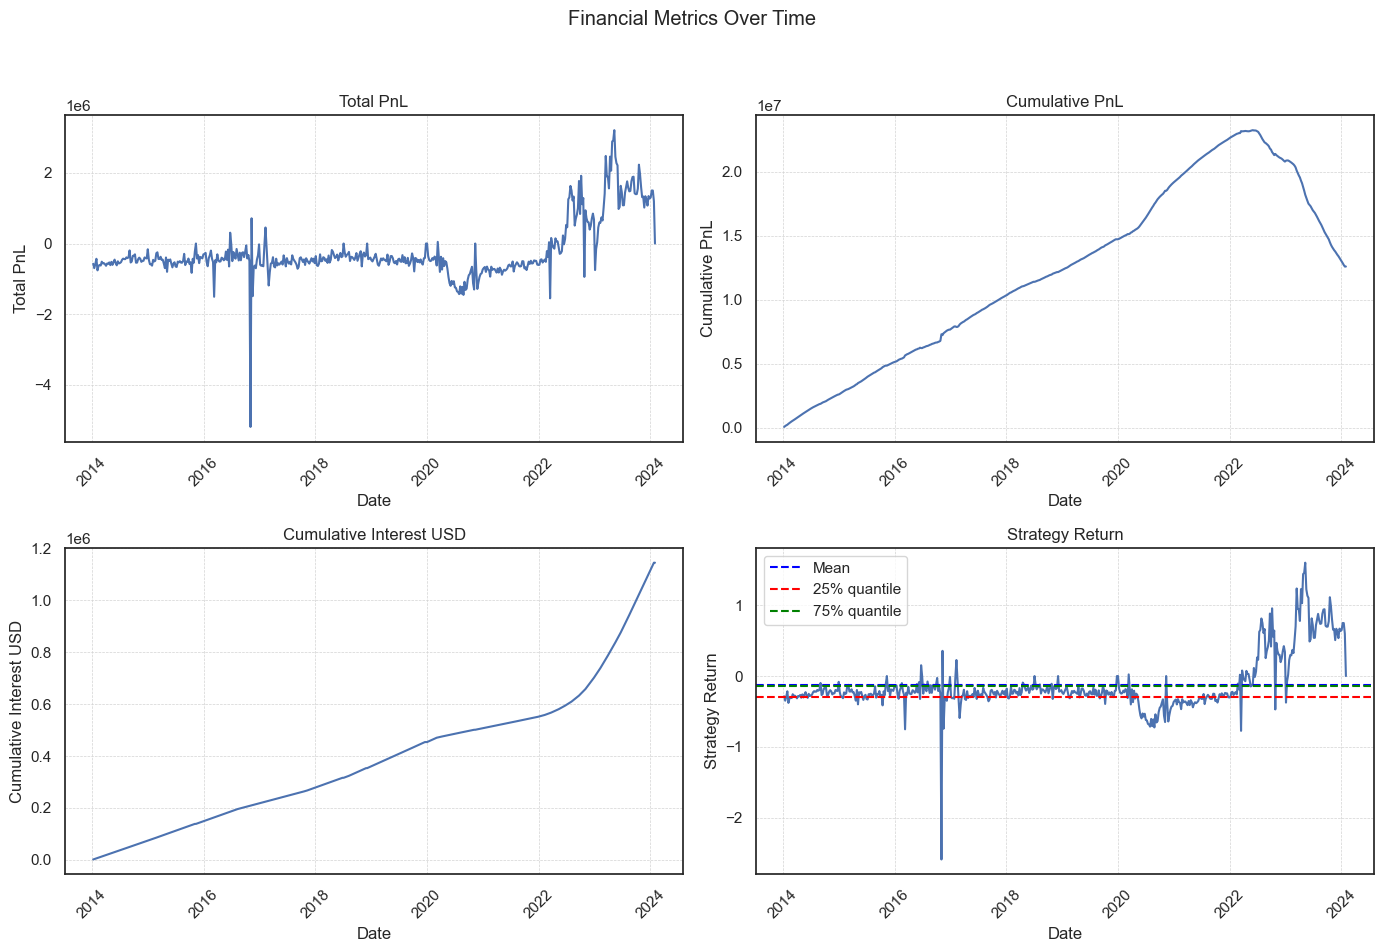

In [1482]:
plot_financial_metrics(EGP_pnl)

In [1483]:
print('The Cumulative PnL for EGP is: $', EGP_pnl['Cumulative PnL'][-1].round(2))

info_cumPnL_EGP = performance_summary(EGP_pnl['Cumulative PnL'])
info_cumPnL_EGP.index = ['EGP - Cumulative PnL']
info_cumPnL_EGP[['Mean', 'Sharpe Ratio', 'Skewness']]


The Cumulative PnL for EGP is: $ 12579421.75


,Mean,Sharpe Ratio,Skewness
EGP - Cumulative PnL,1.474259e+08,6.231,-0.029


In [1484]:
print('The Strategy Return for EGP is: ', (EGP_pnl['Strategy Return'][-2]*100).round(2), '%')

info_returns_EGP = performance_summary(EGP_pnl['Strategy Return'])
info_returns_EGP.index = ['EGP - Strategy Return']
info_returns_EGP[['Mean', 'Volatility', 'Sharpe Ratio', 'Skewness']]

The Strategy Return for EGP is:  59.78 %


,Mean,Volatility,Sharpe Ratio,Skewness
EGP - Strategy Return,-1.435,1.363,-1.053,1.24


The **Total PnL (Profit and Loss)** subplot shows significant fluctuations over time, with some periods of sharp declines suggesting potential losses, and other periods showing gains. The most noticeable drop occurs early in the timeline, with subsequent recovery and growth leading to a sharp increase towards the end of the period. The **Cumulative PnL** graph displays an increasing trend, indicative of overall profitability over time. There is a peak followed by a slight decline towards the end of the period, suggesting recent downturns in performance. Thirdly, the **Cumulative Interest USD** shows a steady increase over time, with a more pronounced rise in the latter years, indicating that the amount of interest accumulated has been consistently growing. Finally, the **Strategy Return** shows the strategy's return, oscillating around the zero line, with horizontal lines indicating the mean, 25%, and 75% quantiles. There are several spikes below the zero line, suggesting periods of negative returns.

For the Egiption Pound the **Cumulative PnL** is approximately $12.58 million, with a very high Sharpe Ratio of 6.231, indicating a favorable risk-adjusted return profile, despite a near-zero skewness suggesting a symmetric distribution of returns. Moreover, the **Strategy Return** for EGP stands at 59.78%, which is substantial. However, the mean strategy return is negative at -1.435%, with high volatility (1.363%) and a negative Sharpe Ratio of -1.053, indicating that the returns are not compensating enough for the risk taken.

In conclusion, while the cumulative metrics suggest profitability, especially for the Cumulative PnL, the Strategy Return indicates that the investment's risk may not be adequately rewarded, as shown by the negative mean and Sharpe Ratio. The skewness and sharp peaks in the Strategy Return graph suggest that the strategy may have periods of significant gains but also substantial risks.

**Hungarian Forint**

In [1485]:
HUF_pnl.head()

,PnL Borrow,PnL Lending,Total PnL,Cumulative PnL,Cumulative PnL Borrow,Cumulative PnL Lending,Cumulative Interest USD,Strategy Return
2014-01-08,37236.934982,-8.914296e+05,-8.541926e+05,85419.263650,37236.934982,-8.914296e+05,1421.099541,-0.427096
2014-01-15,-100390.436105,-1.037570e+06,-1.137960e+06,199215.300189,-63153.501123,-1.929000e+06,2870.809931,-0.568980
2014-01-22,4374.840488,-9.716566e+05,-9.672817e+05,295943.474463,-58778.660635,-2.900656e+06,4298.542844,-0.483641
2014-01-29,119841.721969,-1.009390e+06,-8.895480e+05,384898.277261,61063.061334,-3.910046e+06,5703.536675,-0.444774
2014-02-05,-147335.123108,-8.520750e+05,-9.994101e+05,484839.286077,-86272.061774,-4.762121e+06,7155.853588,-0.499705


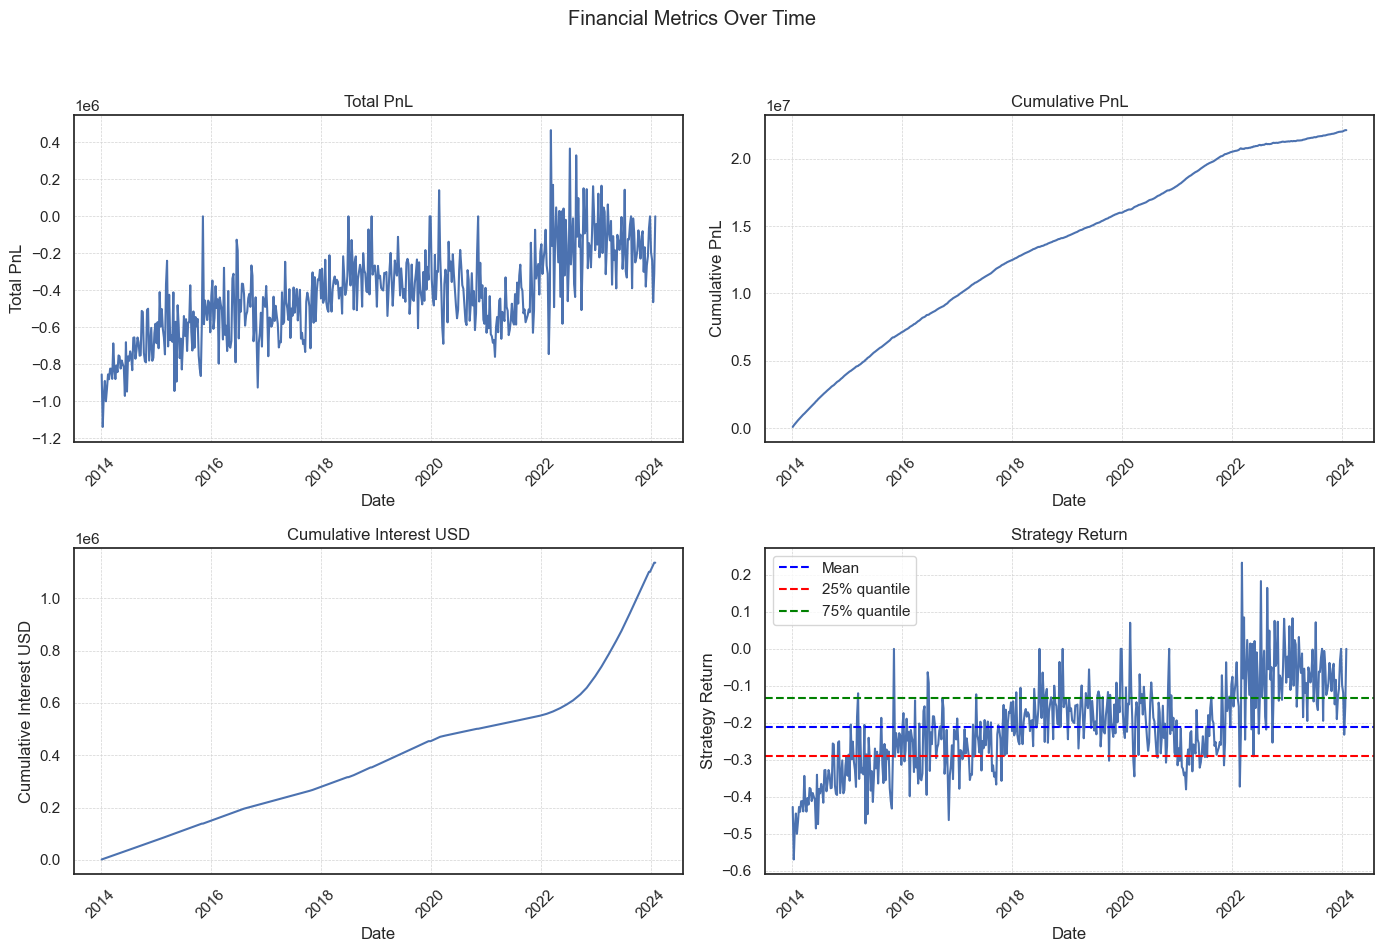

In [1486]:
plot_financial_metrics(HUF_pnl)

In [1487]:
print('The Cumulative PnL for HUF is: $', HUF_pnl['Cumulative PnL'][-1].round(2))

info_cumPnL_HUF = performance_summary(HUF_pnl['Cumulative PnL'])
info_cumPnL_HUF.index = ['HUF - Cumulative PnL']
info_cumPnL_HUF[['Mean', 'Sharpe Ratio', 'Skewness']]


The Cumulative PnL for HUF is: $ 22123808.95


,Mean,Sharpe Ratio,Skewness
HUF - Cumulative PnL,1.628514e+08,7.434,-0.383


In [1488]:
print('The Strategy Return for HUF is: ', (HUF_pnl['Strategy Return'][-2]*100).round(2), '%')

info_returns_HUF = performance_summary(HUF_pnl['Strategy Return'])
info_returns_HUF.index = ['HUF - Strategy Return']
info_returns_HUF[['Mean', 'Volatility', 'Sharpe Ratio', 'Skewness']]

The Strategy Return for HUF is:  -15.49 %


,Mean,Volatility,Sharpe Ratio,Skewness
HUF - Strategy Return,-2.524,0.416,-6.073,0.235


The **Total PnL (Profit and Loss)** displays volatility with no clear trend, indicating periods of both profit and loss with values ranging between approximately -1.2 million to 0.4 million. On the other hand, the **Cumulative PnL** shows a positive trend over time, indicating that despite short-term losses shown in the Total PnL, the overall long-term strategy appears to be profitable. The **Cumulative Interest USD** represent a steady increase in cumulative interest, suggesting a successful accumulation of interest over time, possibly from the reinvestment of earnings or a fixed-income instrument's yield. Finally, the **Strategy Return** illustrates that the returns frequently fall below zero, with the mean also below zero, and quantile lines indicating the range within which most data points fall.

For the Hungarian Forint the **Cumulative PnL for HUF** stands at approximately $22.12 million, indicating profitable performance with a high Sharpe Ratio of 7.434, which suggests good risk-adjusted returns despite a skewness of -0.383 indicating a slight leftward distribution of returns. And as for the **Strategy Return**, they show an overall loss of -15.49%, with a negative mean return of -2.524% and high negative Sharpe Ratio of -6.073, indicating poor performance when adjusted for risk. 

In summary, while the cumulative metrics suggest that the HUF strategy has been profitable overall, the strategy return indicates that when adjusting for the risk (volatility), the strategy's performance is negative, with the mean annualized returns falling below zero. The strategy appears to carry a high risk with frequent negative returns, despite the long-term cumulative profits.

**Costa Rican Colon**

In [1489]:
CRC_pnl.head()

,PnL Borrow,PnL Lending,Total PnL,Cumulative PnL,Cumulative PnL Borrow,Cumulative PnL Lending,Cumulative Interest USD,Strategy Return
2014-01-08,37236.934982,-9.196372e+05,-8.824003e+05,88240.030581,37236.934982,-9.196372e+05,1421.099541,-0.441200
2014-01-15,-100390.436105,-9.210342e+05,-1.021425e+06,190382.493375,-63153.501123,-1.840671e+06,2870.809931,-0.510712
2014-01-22,4374.840488,-9.606990e+05,-9.563242e+05,286014.909856,-58778.660635,-2.801370e+06,4298.542844,-0.478162
2014-01-29,119841.721969,-1.024669e+06,-9.048269e+05,376497.594870,61063.061334,-3.826039e+06,5703.536675,-0.452413
2014-02-05,-147335.123108,-8.442224e+05,-9.915575e+05,475653.342821,-86272.061774,-4.670261e+06,7155.853588,-0.495779


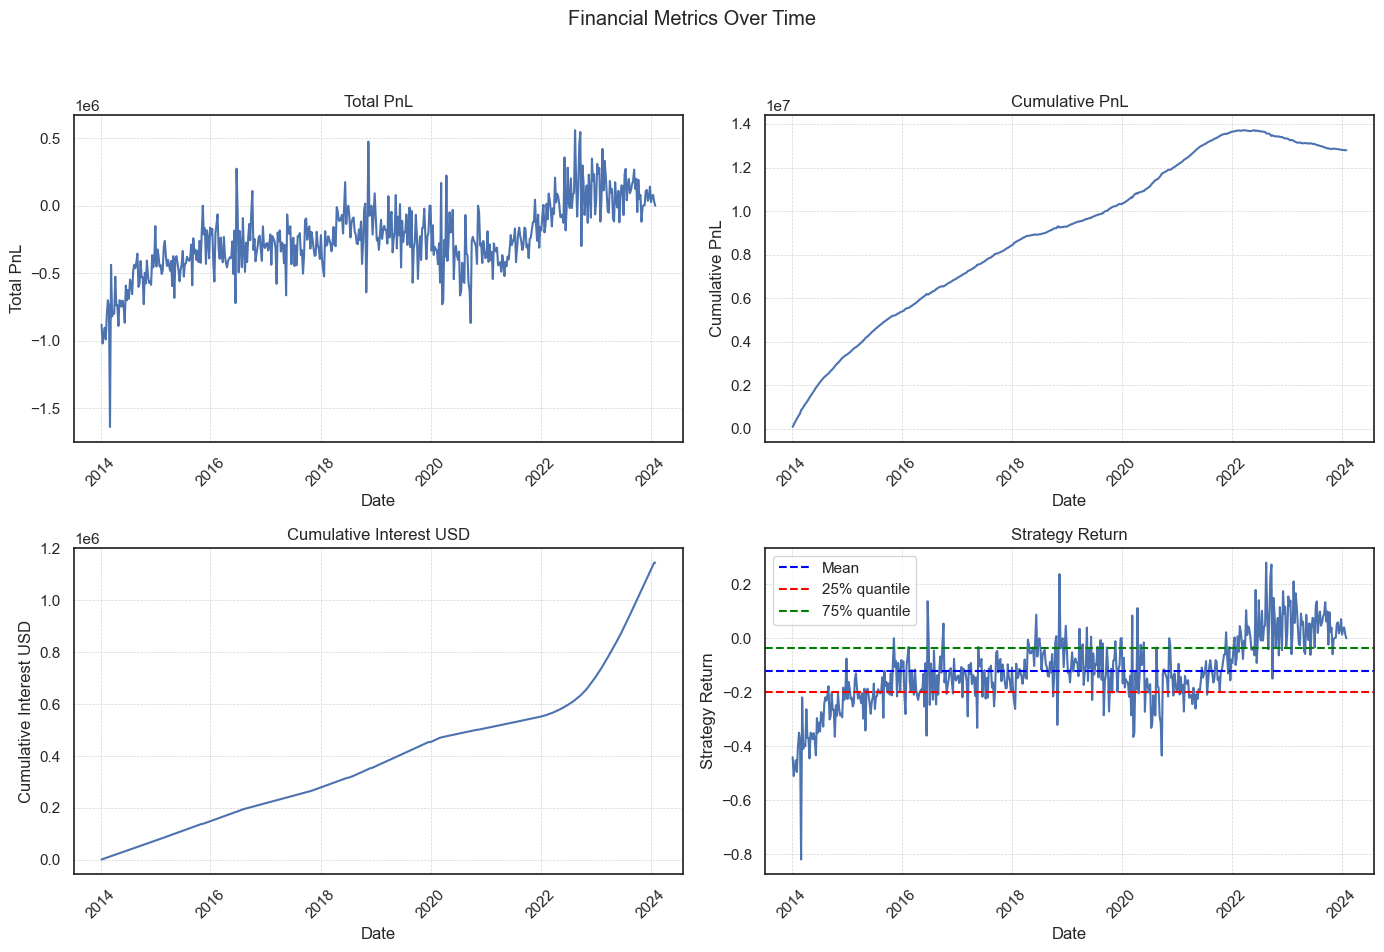

In [1490]:
plot_financial_metrics(CRC_pnl)

In [1491]:
print('The Cumulative PnL for CRC is: $', CRC_pnl['Cumulative PnL'][-1].round(2))

info_cumPnL_CRC = performance_summary(CRC_pnl['Cumulative PnL'])
info_cumPnL_CRC.index = ['CRC - Cumulative PnL']
info_cumPnL_CRC[['Mean', 'Sharpe Ratio', 'Skewness']]

The Cumulative PnL for CRC is: $ 12795305.33


,Mean,Sharpe Ratio,Skewness
CRC - Cumulative PnL,1.083334e+08,8.335,-0.48


In [1492]:
print('The Strategy Return for CRC is: ', (CRC_pnl['Strategy Return'][-2]*100).round(2), '%')

info_returns_CRC = performance_summary(CRC_pnl['Strategy Return'])
info_returns_CRC.index = ['CRC - Strategy Return']
info_returns_CRC[['Mean', 'Volatility', 'Sharpe Ratio', 'Skewness']]

The Strategy Return for CRC is:  1.48 %


,Mean,Volatility,Sharpe Ratio,Skewness
CRC - Strategy Return,-1.46,0.454,-3.213,-0.225


The **Total PnL (Profit and Loss)** shows fluctuation around the zero line with some extreme values, indicating periods of both profit and loss. The graph suggests volatility without a clear upward or downward trend over the long term. The **Cumulative PnL** demonstrates a positive trend with growth over time, suggesting that despite short-term fluctuations seen in the Total PnL, the overall strategy has accumulated significant profits. The **Cumulative Interest USD** illustrates a steady, nearly exponential increase over time, indicating effective interest accrual or a compounding effect of the investment strategy. Finally, the **Strategy Return** shows frequent oscillations around the zero line, with a mean (dotted blue line) slightly below zero, and quantile lines showing the spread of returns. The distribution of returns is skewed left, as indicated by the negative skewness value.

For the Costa Rican Colon the **Cumulative PnL for CRC** is approximately $12.79 million, with an extremely high Sharpe Ratio of 8.335, signifying that the investment's returns are favorable when adjusted for risk, despite a skewness of -0.48 indicating a slight tendency towards more frequent negative outliers. The **Strategy Return for CRC** is positive at 1.48%, but the mean strategy return is negative at -1.46%, with a volatility of 0.454%. The negative Sharpe Ratio of -3.213 suggests that the risk-adjusted returns are not favorable, and the negative skewness of -0.225 implies a distribution with more frequent small losses than gains.

Overall, while the cumulative profit figure and the upward trend in the Cumulative PnL graph suggest that the CRC investment strategy has been profitable over the long term, the Strategy Return indicates potential issues with risk, as the mean return is negative and the risk-adjusted return is poor.

**Romanian Leu**

In [1493]:
RON_pnl.head()

,PnL Borrow,PnL Lending,Total PnL,Cumulative PnL,Cumulative PnL Borrow,Cumulative PnL Lending,Cumulative Interest USD,Strategy Return
2014-01-08,37236.934982,-970675.184567,-9.334382e+05,93343.824958,37236.934982,-9.706752e+05,1421.099541,-0.466719
2014-01-15,-100390.436105,-984951.342785,-1.085342e+06,201878.002848,-63153.501123,-1.955627e+06,2870.809931,-0.542671
2014-01-22,4374.840488,-809316.151626,-8.049413e+05,282372.133961,-58778.660635,-2.764943e+06,4298.542844,-0.402471
2014-01-29,119841.721969,-845663.385483,-7.258217e+05,354954.300313,61063.061334,-3.610606e+06,5703.536675,-0.362911
2014-02-05,-147335.123108,-910498.628888,-1.057834e+06,460737.675512,-86272.061774,-4.521105e+06,7155.853588,-0.528917


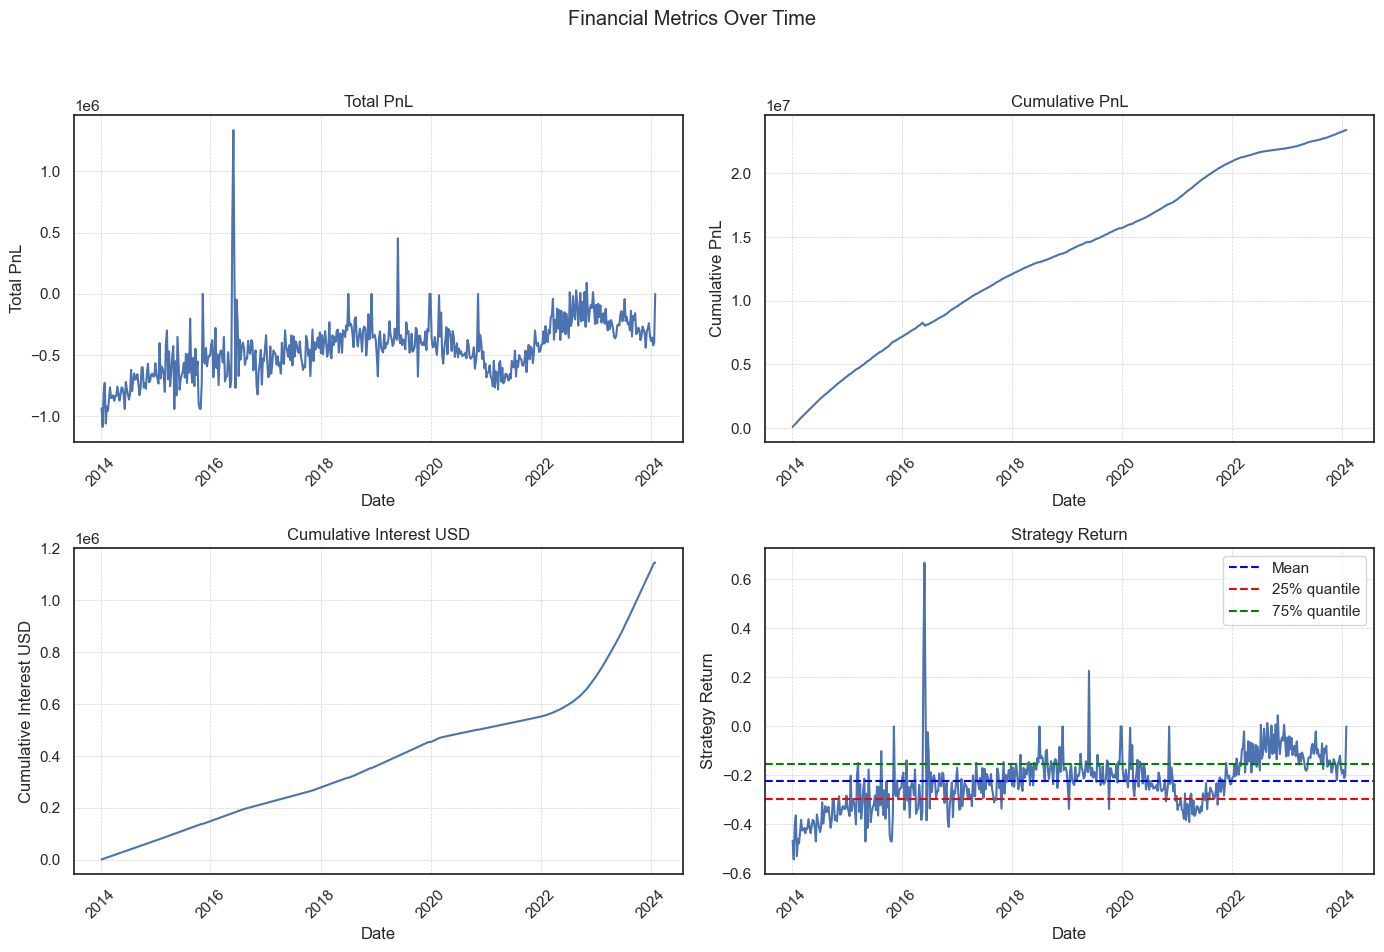

In [1494]:
plot_financial_metrics(RON_pnl)

In [1495]:
print('The Cumulative PnL for RON is: $', RON_pnl['Cumulative PnL'][-1].round(2))

info_cumPnL_RON = performance_summary(RON_pnl['Cumulative PnL'])
info_cumPnL_RON.index = ['RON - Cumulative PnL']
info_cumPnL_RON[['Mean', 'Sharpe Ratio', 'Skewness']]

The Cumulative PnL for RON is: $ 23392710.71


,Mean,Sharpe Ratio,Skewness
RON - Cumulative PnL,1.634892e+08,7.19,-0.241


In [1496]:
print('The Strategy Return for RON is: ', (RON_pnl['Strategy Return'][-2]*100).round(2), '%')

info_returns_RON = performance_summary(RON_pnl['Strategy Return'])
info_returns_RON.index = ['RON - Strategy Return']
info_returns_RON[['Mean', 'Volatility', 'Sharpe Ratio', 'Skewness']]

The Strategy Return for RON is:  -19.94 %


,Mean,Volatility,Sharpe Ratio,Skewness
RON - Strategy Return,-2.668,0.399,-6.68,1.034


The **Total PnL (Profit and Loss)** shows the PnL varying around the zero line, indicating both profits and losses over time with some peaks and troughs, reflecting periods of volatility. The **Cumulative PnL** is upward, suggesting that despite the volatility in the short term, the long-term strategy appears to be profitable. The **Cumulative Interest USD** shows a consistent increase, indicating an effective accumulation of interest over time, which sharply rises towards the later years, likely due to compounding effects or an increase in interest rates. Finally, the **Strategy Return** shows fluctuation around the zero line, with the mean line below zero and the 25% and 75% quantile lines indicating the spread of returns. 

For the Romanian Leu the **Cumulative PnL for RON** is approximately $23.39 million, with a high Sharpe Ratio of 7.19, which suggests a strong risk-adjusted return profile, despite a slight left skew (-0.241), indicating more frequent extreme negative returns than positive ones. The **Strategy Return for RON** shows an overall loss of -19.94%, with a mean annualized return of -2.668% and a high volatility (0.399%). The Sharpe Ratio is deeply negative at -6.68, indicating that the risk-adjusted returns are poor. 

In conclusion, the metrics and the graphs paint a picture of a strategy that has generated a positive cumulative PnL over time but has struggled on a risk-adjusted basis, as evidenced by the negative mean return and Sharpe Ratio.

# 4. Analysis

Study and describe performance. What do correlations of various pairs to each other look like How about market risk factors?

## 4.1. Correlation Analysis

In [1497]:
def compute_correlations(names, *dataframes, title):
    if len(names) != len(dataframes):
        raise ValueError("The number of names must match the number of dataframes")

    combined_df = pd.concat(dataframes, axis=1)
    combined_df.columns = names
    
    correlation_matrix = combined_df.corr()

    sns.set(style='white')
    plt.figure(figsize=(5, 3))
    heatmap = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5)
    plt.title(f'Correlation {title} Heatmap with Values')
    plt.show()

    return correlation_matrix

**Correlation of the 5 Year Yield Data**

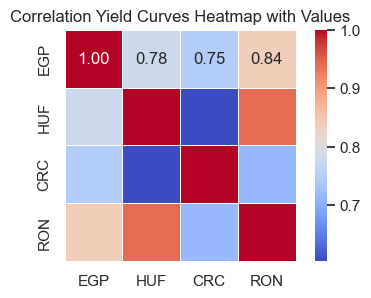

,EGP,HUF,CRC,RON
EGP,1.000000,0.777762,0.748140,0.839061
HUF,0.777762,1.000000,0.604668,0.940246
CRC,0.748140,0.604668,1.000000,0.716539
RON,0.839061,0.940246,0.716539,1.000000


In [1498]:
names = ['EGP', 'HUF', 'CRC', 'RON']
correlation_table_5Y = compute_correlations(names, EGP_YC_5['yield'], HUF_YC_5['yield'], CRC_YC_5['yield'], RON_YC_5['yield'], title='Yield Curves')
correlation_table_5Y

In [1499]:
EGP_YC_5_info = performance_summary(EGP_YC_5['yield'])
HUF_YC_5_info = performance_summary(HUF_YC_5['yield'])
CRC_YC_5_info = performance_summary(CRC_YC_5['yield'])
RON_YC_5_info = performance_summary(RON_YC_5['yield'])

yield_info = pd.concat([EGP_YC_5_info, HUF_YC_5_info, CRC_YC_5_info, RON_YC_5_info], axis=0)
yield_info.index = ['EGP', 'HUF', 'CRC', 'RON']
yield_info[['Mean', 'Volatility', 'Sharpe Ratio', 'Skewness', 'Min', 'Max']]

,Mean,Volatility,Sharpe Ratio,Skewness,Min,Max
EGP,1.088,0.199,5.457,1.970,0.046,0.304
HUF,0.431,0.053,8.179,0.487,0.011,0.081
CRC,0.888,0.048,18.427,0.253,0.050,0.106
RON,0.450,0.058,7.704,1.322,0.015,0.099


The correlation matrix presents the relationship between the 5-year yield data for four different currencies: Egyptian Pound (EGP), Hungarian Forint (HUF), Costa Rican Colon (CRC), and Romanian Leu (RON). 

All the currencies show a positive correlation with each other, which indicates that their yields tend to move in the same direction. The highest correlation is between HUF and RON (0.940246), suggesting their yields are very closely related. The EGP shows strong correlations with all other currencies, particularly with RON (0.839061), indicating that EGP yield movements are a good indicator of RON yield movements and vice versa. However, the CRC shows the least correlation with HUF (0.604668), suggesting that their yields are less synchronized compared to the others.

Regarding the performance metrics, the CRC has the highest mean yield (0.888), while HUF has the lowest (0.431). Moreover, CRC has an exceptionally high Sharpe Ratio (18.427), which suggests a very favorable return compared to the risk taken. HUF also has a high Sharpe Ratio (8.179), indicating efficient risk-adjusted returns. Finally, EGP experienced the highest maximum yield (0.304), indicating a higher potential for gains, whereas HUF had the lowest maximum yield (0.081).

In summary, the correlation matrix indicates that while the yields of these currencies tend to move together, there are differences in how closely they are related. From a performance standpoint, CRC stands out with the highest mean and an exceptional Sharpe Ratio, indicating high returns for lower risk, while EGP, despite its high mean return, also bears high volatility and skewness, suggesting a riskier profile. HUF and RON exhibit lower mean yields but maintain high Sharpe Ratios, indicating effective risk-adjusted performance.

**Correlation of the FX Rates**

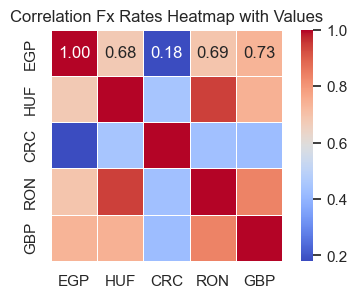

,EGP,HUF,CRC,RON,GBP
EGP,1.000000,0.678946,0.181163,0.689829,0.734899
HUF,0.678946,1.000000,0.447501,0.943573,0.742663
CRC,0.181163,0.447501,1.000000,0.430891,0.421596
RON,0.689829,0.943573,0.430891,1.000000,0.837913
GBP,0.734899,0.742663,0.421596,0.837913,1.000000


In [1500]:
names = ['EGP', 'HUF', 'CRC', 'RON', 'GBP']
correlation_table_rates = compute_correlations(names, EGP_data['rate'], HUF_data['rate'], CRC_data['rate'], RON_data['rate'], GBP_data['rate'], title='Fx Rates')
correlation_table_rates

In [1501]:
EGP_data_info = performance_summary(EGP_data['rate'])
HUF_data_info = performance_summary(HUF_data['rate'])
CRC_data_info = performance_summary(CRC_data['rate'])
RON_data_info = performance_summary(RON_data['rate'])
GBP_data_info = performance_summary(GBP_data['rate'])

data_info = pd.concat([EGP_data_info, HUF_data_info, CRC_data_info, RON_data_info, GBP_data_info], axis=0)
data_info.index = ['EGP', 'HUF', 'CRC', 'RON', 'GBP']
data_info[['Mean', 'Volatility', 'Sharpe Ratio', 'Skewness', 'Min', 'Max']]

,Mean,Volatility,Sharpe Ratio,Skewness,Min,Max
EGP,192.171,23.312,8.243,0.647,6.958,30.950
HUF,3565.688,143.578,24.834,0.776,220.322,441.394
CRC,6879.837,133.412,51.568,0.796,500.085,691.822
RON,49.647,1.287,38.587,-0.382,3.189,5.188
GBP,8.929,0.237,37.725,-0.612,0.583,0.939


The correlation matrix for the FX rates shows the relationship between the exchange rates of the five different countries. 

The RON and HUF have a very high correlation of 0.943573, suggesting their exchange rates against other currencies move in tandem. Also, EGP is moderately correlated with GBP, HUF, and RON, indicating some level of synchronous movement in their exchange rates. Lastly, the CRC has low to moderate correlations with the other currencies, indicating its exchange rate movements are less in sync with those currencies.

Regarding the performance metrics, CRC has the highest average exchange rate (6879.837), which could be due to its lower value compared to the reference currency, and HUF follows with 3565.688. HUF has the highest volatility (143.578), suggesting its exchange rate is the most unstable, while GBP has the lowest (0.237), indicating stability. CRC stands out with an exceptionally high Sharpe Ratio (51.568), indicating its exchange rate fluctuations offer favorable returns relative to the risk. CRC has the widest range between its minimum and maximum values (500.085 to 691.822), and GBP has the narrowest (0.583 to 0.939).

In summary, the correlation matrix indicates varied degrees of correlation between these currency exchange rates, with RON and HUF showing a strong positive relationship. In terms of performance metrics, CRC exhibits high average exchange rates and an outstanding Sharpe Ratio, implying high returns per unit of risk. HUF shows significant volatility but also a high Sharpe Ratio, suggesting its exchange rate movements are profitable despite the higher risk. GBP stands out for its stability and high Sharpe Ratio despite a negative skewness, indicating consistent performance with fewer extreme negative deviations.

**Correlation of Strategy Returns**

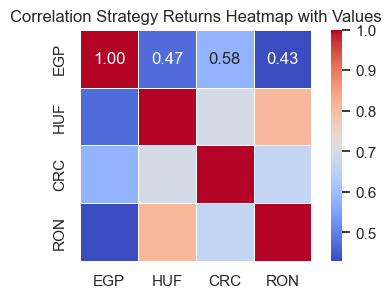

,EGP,HUF,CRC,RON
EGP,1.000000,0.471471,0.580378,0.430129
HUF,0.471471,1.000000,0.696935,0.810269
CRC,0.580378,0.696935,1.000000,0.666085
RON,0.430129,0.810269,0.666085,1.000000


In [1502]:
names = ['EGP', 'HUF', 'CRC', 'RON']
correlation_table_returns = compute_correlations(names, EGP_pnl['Strategy Return'], HUF_pnl['Strategy Return'], CRC_pnl['Strategy Return'], RON_pnl['Strategy Return'], title='Strategy Returns')
correlation_table_returns

In [1503]:
EGP_returns_info = performance_summary(EGP_pnl['Strategy Return'])
HUF_returns_info = performance_summary(HUF_pnl['Strategy Return'])
CRC_returns_info = performance_summary(CRC_pnl['Strategy Return'])
RON_returns_info = performance_summary(RON_pnl['Strategy Return'])

returns_info = pd.concat([EGP_returns_info, HUF_returns_info, CRC_returns_info, RON_returns_info], axis=0)
returns_info.index = ['EGP', 'HUF', 'CRC', 'RON']
returns_info[['Mean', 'Volatility', 'Sharpe Ratio', 'Skewness', 'Min', 'Max']]

,Mean,Volatility,Sharpe Ratio,Skewness,Min,Max
EGP,-1.435,1.363,-1.053,1.240,-2.593,1.602
HUF,-2.524,0.416,-6.073,0.235,-0.569,0.233
CRC,-1.460,0.454,-3.213,-0.225,-0.820,0.280
RON,-2.668,0.399,-6.680,1.034,-0.543,0.668


The correlation matrix shows the strategy returns for four different currencies.

The HUF and RON have the highest correlation (0.810269), suggesting that their strategy returns move more closely together compared to others. THe EGP shows moderate correlations with HUF and CRC, but a lower one with RON, indicating some level of synchrony but less so with the Romanian Leu. and the CRC's strategy returns have relatively high correlations with all other currencies. 

Regarding the performance metrics, all currencies show negative mean returns, indicating an overall loss in the strategies. EGP has the highest volatility (1.363), which implies that its strategy returns fluctuate the most. RON has the lowest volatility (0.399), suggesting its strategy returns are more stable. Moreover, all four currencies have negative Sharpe Ratios, with HUF and RON having particularly low ratios (-6.073 and -6.680 respectively), indicating poor risk-adjusted returns. Lastly, EGP's strategy had the widest range between its minimum and maximum returns, which indicates higher risk from extreme movements.

In summary, while the strategy returns for these currencies are positively correlated, suggesting some common underlying factors affecting them, all strategies have yielded negative mean returns. The volatility of these strategies varies, with EGP being the most volatile and RON the least. The negative Sharpe Ratios across the board indicate that the excess return of the strategies over the risk-free rate does not compensate for the risk taken. The skewness values suggest asymmetry in the returns distribution, with some strategies prone to large positive swings and others to small losses.

## 4.2. Risk Analysis

**Correlation of the 5 Year Yield Data**

In [1504]:
yield_info = pd.concat([EGP_YC_5_info, HUF_YC_5_info, CRC_YC_5_info, RON_YC_5_info], axis=0)
yield_info.index = ['EGP', 'HUF', 'CRC', 'RON']
yield_info[['VaR (0.05)', 'CVaR (0.05)']]

,VaR (0.05),CVaR (0.05)
EGP,0.051,0.049
HUF,0.013,0.012
CRC,0.052,0.051
RON,0.018,0.017


The **VaR (0.05)** is a risk metric that estimates the maximum potential loss over a given time frame with a 95% confidence level. The EGP and CRC have higher VaR figures (0.051 and 0.052 respectively), suggesting that there's a higher risk of loss. And the HUF and RON have lower VaR figures (0.013 and 0.018 respectively), indicating a lower risk of extreme negative returns.

The **CVaR (0.05)** or Expected Shortfall, CVaR calculates the average of the losses that occur beyond the VaR point in the tail of the distribution. Similar to VaR, EGP and CRC have higher CVaR figures (0.049 and 0.051), which means that, in the worst 5% of cases, their average losses are larger. HUF and RON have lower CVaR figures (0.012 and 0.017), implying that their average losses in the worst 5% of cases are less severe.

**Correlation of the FX Rates**

In [1505]:
data_info = pd.concat([EGP_data_info, HUF_data_info, CRC_data_info, RON_data_info, GBP_data_info], axis=0)
data_info.index = ['EGP', 'HUF', 'CRC', 'RON', 'GBP']
data_info[['VaR (0.05)', 'CVaR (0.05)']]

,VaR (0.05),CVaR (0.05)
EGP,7.150,7.025
HUF,228.151,224.383
CRC,531.264,519.389
RON,3.313,3.250
GBP,0.603,0.594


The **VaR (0.05)** for the HUF and CRC shows significantly high values suggesting a greater risk of loss in adverse market conditions compared to other currencies. On the other hand, GBP has the lowest VaR at 0.603, indicating it is perceived as the least risky among the currencies listed in terms of potential losses.

Regarding the **CVaR (0.05)**, the HUF and CRC have the highest CVaR values implying that in the event of losses, they are expected to be larger on average than those for the other currencies.

These figures suggest that HUF and CRC carry more risk in terms of potential losses compared to EGP, RON, and GBP. The GBP appears to be the most stable currency among the group with the lowest potential for extreme losses. 

**Correlation of Strategy Returns**

In [1506]:
returns_info = pd.concat([EGP_returns_info, HUF_returns_info, CRC_returns_info, RON_returns_info], axis=0)
returns_info.index = ['EGP', 'HUF', 'CRC', 'RON']
returns_info[['VaR (0.05)', 'CVaR (0.05)']]

,VaR (0.05),CVaR (0.05)
EGP,-0.502,-0.703
HUF,-0.399,-0.442
CRC,-0.349,-0.414
RON,-0.406,-0.441


The **VaR (0.05)** shows that EGP has the highest potential loss (as indicated by the most negative VaR of -0.502), suggesting it's the riskiest strategy among the four. CRC appears to have the lowest potential loss at the 5% level (VaR of -0.349), implying it's the least risky in terms of extreme negative returns.

Regarding the **CVaR (0.05)**, it shows that EGP also has the most negative CVaR of -0.703, which means that in the worst-case scenarios, its average losses are greater than those of the other currencies. And CRC's strategy returns, while having the least negative VaR, also have a relatively better (less negative) CVaR of -0.414, reinforcing its position as having lower risk in extreme market conditions compared to the others.

# 5. Conclusions

The selected currencies showcase a range of interest rate environments, from the higher rates in emerging markets (EGP, CRC) to the lower rates in developed markets (GBP, USD). This diversity highlights the core of the FX carry strategy, exploiting these differences to capture interest rate spreads. The analysis reveals significant volatility in strategy returns, with EGP displaying the highest volatility. Such volatility underlines the inherent risks of the FX carry strategy, particularly in emerging markets where economic and political factors can lead to abrupt currency value changes. Negative Sharpe Ratios across all examined currencies indicate that the returns, when adjusted for risk, are not compensating for the volatility experienced. This is particularly pronounced for HUF and RON, suggesting that while their correlation might offer some predictability, the risk-adjusted returns are unfavorable.

The Value at Risk and Conditional Value at Risk metrics emphasize the potential for substantial losses, especially in EGP and CRC strategies. These metrics are crucial for understanding the worst-case scenarios and the average losses beyond the VaR threshold. The strong correlation between HUF and RON strategy returns might suggest similar underlying economic or market factors affecting these currencies. However, the diversification benefits may be limited when these currencies are paired in a carry trade strategy due to their synchronized movements.

While the carry trade offers potential opportunities for profit, especially in high-interest-rate environments, it comes with considerable risks. These include not only the volatility of currency values but also the exposure to sudden economic shifts and policy changes in the involved countries. Investors engaging in FX carry trades must carefully consider both the interest rate differentials and the potential for adverse currency movements. Risk management techniques, including diversification across multiple currency pairs and the use of stop-loss orders, are essential to mitigate potential losses.

In summary, while the FX carry strategy presents opportunities for leveraging interest rate differentials between currencies, it requires a nuanced understanding of the associated risks, particularly those stemming from currency volatility and economic instability. Effective execution of this strategy necessitates a comprehensive analysis of the involved currencies, attention to global economic indicators, and stringent risk management practices.